In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# ipynb에서 디폴트로 이벤트루프를 돌리고 있어서 해당 설정을 안 해주면 async를 돌릴 때 에러가 난다.
import nest_asyncio

nest_asyncio.apply()

In [ ]:
from pyzerox import zerox
import os
import json
import asyncio

### Model Setup (Use only Vision Models) Refer: https://docs.litellm.ai/docs/providers ###

## placeholder for additional model kwargs which might be required for some models
kwargs = {}

## system prompt to use for the vision model
custom_system_prompt = None

# to override
# custom_system_prompt = "For the below PDF page, do something..something..." ## example

###################### Example for OpenAI ######################
model = "gpt-4o-mini" ## openai model

# Define main async entrypoint
async def main():
    file_path = "./documents/income_tax.pdf" ## local filepath and file URL supported

    ## process only some pages or all
    select_pages = None ## None for all, but could be int or list(int) page numbers (1 indexed)

    output_dir = "./documents/income_tax.md" ## directory to save the consolidated markdown file
    result = await zerox(file_path=file_path, model=model, output_dir=output_dir,
                        custom_system_prompt=custom_system_prompt,select_pages=select_pages, **kwargs)
    return result


# run the main function:
result = asyncio.run(main())

# print markdown result
print(result)

In [ ]:
import markdown
from bs4 import BeautifulSoup

markdown_path = './documents/income_tax.md'
text_path = './documents/income_tax.txt'

with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read() 

# 마크다운 HTML로 변환
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader

text_path = './documents/income_tax.txt'

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 100,
    separators=['\n\n', '\n']
)

loader = TextLoader(text_path, encoding='utf-8')
document_list = loader.load_and_split(text_splitter)

In [3]:
from dotenv import load_dotenv
from langchain_upstage import UpstageEmbeddings
from langchain_chroma import Chroma

embeddings = UpstageEmbeddings(model="solar-embedding-1-large")

# Chroma는 기본적으로 in-memory VertorDB이며, persist_directory 옵션을 추가하면 해당 경로에 파일로 저장된다.
# 한번 파일로 저장해놓으면, 메모리가 초기화되어도 documents를 넣어서 다시 임베딩할 필요 없다. 

vector_store = Chroma.from_documents(documents=document_list,
                                     embedding=embeddings,
                                     collection_name="income_tax_collection",
                                     persist_directory="./income_tax_collection")

# database = Chroma(collection_name="chroma-tax",
#                   embedding_function=embedding,
#                   persist_directory="./chroma")

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

### 1. state, graph_builder 정의

In [4]:
# START -> retrieve -> generate -> END
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list[Document]
    answer: str

graph_builder = StateGraph(AgentState)

### 2. node에 들어갈 function 정의

In [5]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [6]:
from langchain import hub
from langchain_upstage import ChatUpstage

llm = ChatUpstage()
prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    query = state['query']
    context = state['context']
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response}

c:\Users\hyunseo\Desktop\learn_langgraph\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### 3. node 정의

In [7]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

### 4. edge 정의

In [8]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate')
graph_builder.add_edge('generate', END)

### 5. graph_complie, display

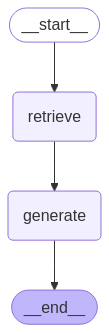

In [9]:
from IPython.display import Image, display

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [10]:
query = "연봉 5천만원 직장인의 소득세는?"
initial_state = {'query': query}
graph.invoke(initial_state)

{'query': '연봉 5천만원 직장인의 소득세는?',
 'context': [Document(id='f4e9684c-d1e8-4427-9727-4ab8dbb597f8', metadata={'source': './documents/income_tax.txt'}, page_content='| 종합소득 과세표준          | 세율                                         |\n|-------------------|--------------------------------------------|\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n| 8,800만원 초과 1억5천만원 이하    | 3,706만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|'),
  Document(id='05aa221c-2aa8-46bf-979c-70bc52d7a521', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 

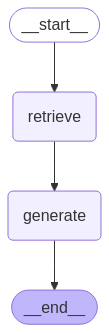

In [20]:
# sequence의 경우, add_node로 일일이 추가하는 것이 아니라, add_sequence로 한번에 할 수도 있다

sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])

sequence_graph_builder.add_edge(START, 'retrieve')
sequence_graph_builder.add_edge('generate', END)

sequence_graph = sequence_graph_builder.compile()

display(Image(sequence_graph.get_graph().draw_mermaid_png()))